# Sentiment

In [1]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

from utils import load_data, load_test_names, load_nyc_names, print_summary
from SenSR import train_nn, train_fair_nn

In [49]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download (and unpack) positive and negative words from
# http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar
# and put them into
data_path = './sentiment'

In [4]:
# Download Common Crawl (42B tokens) GloVe word embeddings from
# https://nlp.stanford.edu/projects/glove/
# and put them into
embeddings_path = './embeddings/glove.42B.300d.txt'

In [5]:
# Download Popular Baby Names in CSV format from
# https://catalog.data.gov/dataset/most-popular-baby-names-by-sex-and-mothers-ethnic-group-new-york-city-8c742
# and put them into
nyc_names_path = './nyc_names/Popular_Baby_Names.csv'

In [6]:
## Load data and embeddings
# Loading GloVe might take couple of minutes
embeddings, X_train, X_test, y_train, y_test, train_vocab, test_vocab = load_data(data_path, embeddings_path)

/Users/cplu/Downloads/Documents/Fall2021/588/fairML/sensitive-subspace-robustness/utils.py:55: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  pos_vectors = embeddings.loc[pos_words].dropna()
/Users/cplu/Downloads/Documents/Fall2021/588/fairML/sensitive-subspace-robustness/utils.py:56: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  neg_vectors = embeddings.loc[neg_words].dropna()


In [21]:
y_train.shape, y_test.shape

((5966, 2), (663, 2))

In [7]:
## Load test names and their embeddings
test_df, test_names_embed = load_test_names(embeddings)

In [8]:
test_df.shape

(94, 3)

In [9]:
## Load Popular NYC Baby Names and their embeddings
nyc_names_embed = load_nyc_names(nyc_names_path, embeddings)

In [10]:
nyc_names_embed.shape

(14265, 300)

In [11]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Baseline experiment (NN)

Instructions for updating:
Colocations handled automatically by placer.

Final train accuracy 0.956587
Final test accuracy 0.941176
baseline test accuracy 0.941176
baseline Black mean sentiment is 0.312849
baseline White mean sentiment is 2.956999
baseline race mean sentiment difference is 2.644150

baseline Female mean sentiment is 2.449749
baseline Male mean sentiment is 0.964222
baseline gender mean sentiment difference is 1.485527



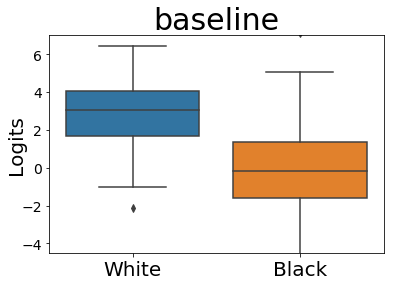

In [12]:
## Baseline
baseline_weights, _, baseline_test_logits = train_nn(X_train, y_train, X_test=X_test, y_test=y_test, epoch=2000, batch_size=1000)
baseline_accuracy = (baseline_test_logits.argmax(axis=1)==y_test.argmax(axis=1)).mean()
_, baseline_names_logits, _ = train_nn(test_names_embed, y_train=None, weights=baseline_weights, epoch=0)
test_df['baseline_logits'] = baseline_names_logits[:,1] - baseline_names_logits[:,0]
print_summary(test_df, 'baseline', baseline_accuracy)

In [33]:
test_df.head()

,name,race,gender,baseline_logits
0,adam,White,Male,6.450377
1,chip,White,Male,-1.040717
2,harry,White,Male,1.668889
3,josh,White,Male,4.902444
4,roger,White,Male,1.584226


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
def print_summary(test_df, method_name, test_accuracy):
    
    print(method_name + ' test accuracy %f' % test_accuracy)
    mean_sentiments_race = []
    for r in ['Black', 'White']:
        mean_sent = test_df[method_name + '_logits'][test_df['race']==r].mean()
        mean_sentiments_race.append(mean_sent)
        print(method_name + ' %s mean sentiment is %f' %(r, mean_sent))
    print(method_name + ' race mean sentiment difference is %f\n' % np.abs(mean_sentiments_race[0] - mean_sentiments_race[1]))
    
    mean_sentiments_gender = []
    for g in ['Female', 'Male']:
        mean_sent = test_df[method_name + '_logits'][test_df['gender']==g].mean()
        mean_sentiments_gender.append(mean_sent)
        print(method_name + ' %s mean sentiment is %f' %(g, mean_sent))
    print(method_name + ' gender mean sentiment difference is %f\n' % np.abs(mean_sentiments_gender[0] - mean_sentiments_gender[1]))
    

    sns.boxplot(x='race', y=method_name + '_logits', data=test_df).set_title(method_name, fontsize=30)
    plt.ylim(-5, 7)
    plt.xlabel('')
    plt.ylabel('Logits', size=20, labelpad=-5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=14)
    plt.show()

    return

baseline test accuracy 0.941176
baseline Black mean sentiment is 0.312849
baseline White mean sentiment is 2.956999
baseline race mean sentiment difference is 2.644150

baseline Female mean sentiment is 2.449749
baseline Male mean sentiment is 0.964222
baseline gender mean sentiment difference is 1.485527



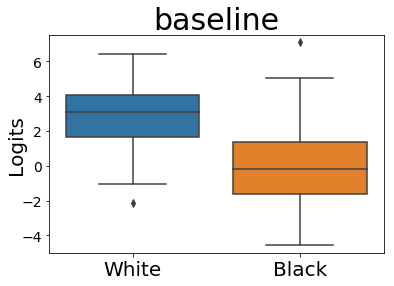

In [20]:
print_summary(test_df, 'baseline', baseline_accuracy)

baseline test accuracy 0.941176
baseline Black mean sentiment is 0.312849
baseline White mean sentiment is 2.956999
baseline race mean sentiment difference is 2.644150

baseline Female mean sentiment is 2.449749
baseline Male mean sentiment is 0.964222
baseline gender mean sentiment difference is 1.485527



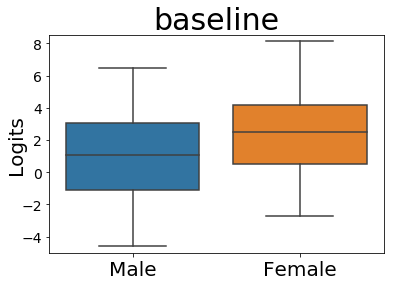

In [29]:
print_summary(test_df, 'baseline', baseline_accuracy)

In [42]:
test_df.head()

,name,race,gender,baseline_logits,sensr0_expert_logits,sensr0_logits
0,adam,White,Male,6.450377,-0.345438,1.562763
1,chip,White,Male,-1.040717,-0.349299,0.350032
2,harry,White,Male,1.668889,-0.347564,0.395830
3,josh,White,Male,4.902444,-0.344976,2.205281
4,roger,White,Male,1.584226,-0.347626,-0.225431



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please switch to tf.train.get_or_create_global_step

Final train accuracy 0.92759
Final test accuracy 0.923077
sensr0_expert test accuracy 0.923077
sensr0_expert Black mean sentiment is -0.348363
sensr0_expert White mean sentiment is -0.351193
sensr0_expert race mean sentiment difference is 0.002830

sensr0_expert Female mean sentiment is -0.351948
sensr0_expert Male mean sentiment is -0.347817
sensr0_expert gender mean sentiment difference is 0.004131



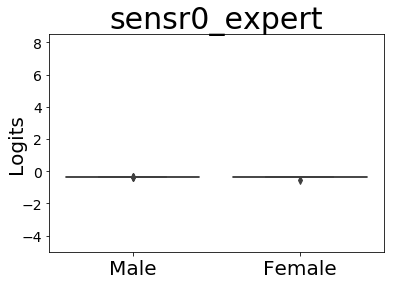

In [35]:
## SenSR_0 expert
expert_sens_directions = np.copy(test_names_embed)
sensr0_expert_weights, _, sensr0_expert_test_logits = train_fair_nn(X_train, y_train, expert_sens_directions, X_test = X_test, y_test=y_test)
sensr0_expert_accuracy = (sensr0_expert_test_logits.argmax(axis=1)==y_test.argmax(axis=1)).mean()
_, sensr0_expert_names_logits, _ = train_nn(test_names_embed, y_train=None, weights=sensr0_expert_weights, epoch=0)
test_df['sensr0_expert_logits'] = sensr0_expert_names_logits[:,1] - sensr0_expert_names_logits[:,0]
print_summary(test_df, 'sensr0_expert', sensr0_expert_accuracy)


sensr0_expert test accuracy 0.923077
sensr0_expert Black mean sentiment is -0.348363
sensr0_expert White mean sentiment is -0.351193
sensr0_expert race mean sentiment difference is 0.002830

sensr0_expert Female mean sentiment is -0.351948
sensr0_expert Male mean sentiment is -0.347817
sensr0_expert gender mean sentiment difference is 0.004131



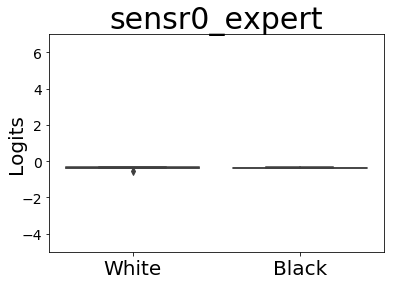

In [37]:
print_summary(test_df, 'sensr0_expert', sensr0_expert_accuracy)

In [38]:
## SenSR_0
# Learning sensitive direction from Popular Baby Names
tSVD = TruncatedSVD(n_components=50)
tSVD.fit(nyc_names_embed)
svd_sens_directions = tSVD.components_


Final train accuracy 0.938485
Final test accuracy 0.932127
sensr0 test accuracy 0.932127
sensr0 Black mean sentiment is 0.315570
sensr0 White mean sentiment is 0.089544
sensr0 race mean sentiment difference is 0.226026

sensr0 Female mean sentiment is 0.330003
sensr0 Male mean sentiment is 0.071004
sensr0 gender mean sentiment difference is 0.258999



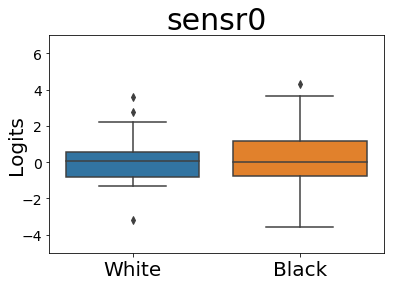

In [39]:
sensr0_weights, _, sensr0_test_logits = train_fair_nn(X_train, y_train, svd_sens_directions, X_test = X_test, y_test=y_test)
sensr0_accuracy = (sensr0_test_logits.argmax(axis=1)==y_test.argmax(axis=1)).mean()
_, sensr0_names_logits, _ = train_nn(test_names_embed, y_train=None, weights=sensr0_weights, epoch=0)
test_df['sensr0_logits'] = sensr0_names_logits[:,1] - sensr0_names_logits[:,0]
print_summary(test_df, 'sensr0', sensr0_accuracy)

sensr0 test accuracy 0.932127
sensr0 Black mean sentiment is 0.315570
sensr0 White mean sentiment is 0.089544
sensr0 race mean sentiment difference is 0.226026

sensr0 Female mean sentiment is 0.330003
sensr0 Male mean sentiment is 0.071004
sensr0 gender mean sentiment difference is 0.258999



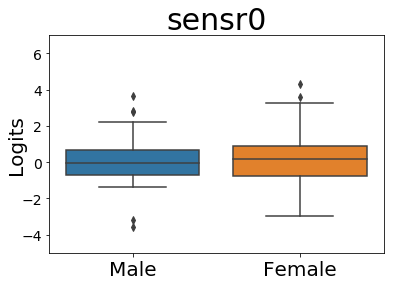

In [44]:
print_summary(test_df, 'sensr0', sensr0_accuracy)

Instructions for updating:
Use tf.cast instead.

Final train accuracy 0.940664
Final test accuracy 0.927602
Final lambda 3.387387
sensr test accuracy 0.927602
sensr Black mean sentiment is 0.224193
sensr White mean sentiment is 0.154852
sensr race mean sentiment difference is 0.069341

sensr Female mean sentiment is 0.242530
sensr Male mean sentiment is 0.135835
sensr gender mean sentiment difference is 0.106695



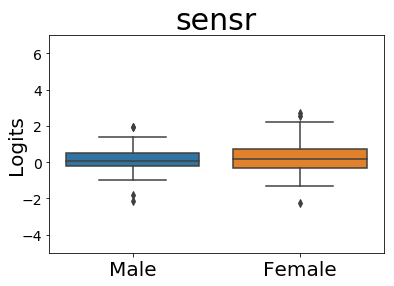

In [45]:
## SenSR
sensr_weights, _, sensr_test_logits = train_fair_nn(X_train, y_train, svd_sens_directions, X_test = X_test, y_test=y_test, full_step=0.01, eps=0.1)
sensr_accuracy = (sensr_test_logits.argmax(axis=1)==y_test.argmax(axis=1)).mean()
_, sensr_names_logits, _ = train_nn(test_names_embed, y_train=None, weights=sensr_weights, epoch=0)
test_df['sensr_logits'] = sensr_names_logits[:,1] - sensr_names_logits[:,0]
print_summary(test_df, 'sensr', sensr_accuracy)

sensr test accuracy 0.927602
sensr Black mean sentiment is 0.224193
sensr White mean sentiment is 0.154852
sensr race mean sentiment difference is 0.069341

sensr Female mean sentiment is 0.242530
sensr Male mean sentiment is 0.135835
sensr gender mean sentiment difference is 0.106695



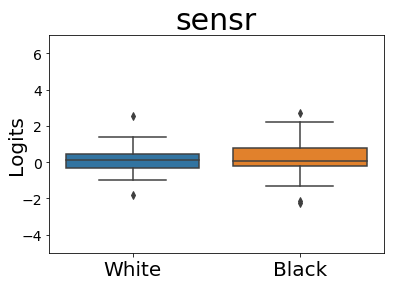

In [47]:
print_summary(test_df, 'sensr', sensr_accuracy)

# adult

In [2]:
!conda install aif360

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - anaconda/osx-64::spyder==3.3.2=py37_0
  - anaconda/osx-64::anaconda==2018.12=py37_0
done

## Package Plan ##

  environment location: /Users/cplu/anaconda3

  added / updated specs:
    - aif360


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _anaconda_depends-2019.10  |           py37_0           5 KB
    aif360-0.3.0               |             py_0         108 KB  conda-forge
    ca-certificates-2020.10.14 |                0         127 KB
    certifi-2020.11.8          |   py37hecd8cb5_0         151 KB
    conda-4.9.2                |   py37hecd8cb5_0         3.1 MB
    fsspec-0.8.3               |             py_0          69 KB
    joblib-0.17.0              |             py_0         205 KB
    json5-0.9.5                |   

In [3]:
!y

/bin/sh: y: command not found
